In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# This is for if we're trying to execute on a remote JupyterHub, where the pwd is set to the server root, or else I think pwd is set correctly already.
%cd CD_Circuit/

[Errno 2] No such file or directory: 'CD_Circuit/'
/accounts/projects/binyu/georgiasimpression/CD_Circuit/notebooks


In [3]:
import argparse
import numpy as np
import os
import pandas as pd
import scipy as sp
import sys
import torch
import torch.nn.functional as F
import warnings
import random
import collections

# CD-T Imports
import math
import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import itertools

from torch import nn

warnings.filterwarnings("ignore")

base_dir = os.path.split(os.getcwd())[0]
sys.path.append(base_dir)

from argparse import Namespace
from methods.bag_of_ngrams.processing import cleanReports, cleanSplit, stripChars
from pyfunctions.general import extractListFromDic, readJson, combine_token_attn, compute_word_intervals
from pyfunctions.pathology import extract_synoptic, fixLabelProstateGleason, fixProstateLabels, fixLabel, exclude_labels
from pyfunctions.cdt_basic import *
from pyfunctions.cdt_source_to_target import *
from pyfunctions.ioi_dataset import IOIDataset
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset
from transformers import AutoTokenizer, AutoModel
from transformers import GPT2Tokenizer, GPT2Model

In [4]:
torch.autograd.set_grad_enabled(False)

## Load Model

Note: Unlike with the BERT model + medical dataset objective, it is not necessary to pretrain GPT-2 to perform the IOI dataset.
GPT-2-small is already capable of performing IOI; that's part of the point of the Mech Interp in the Wild paper.
We only need to examine how it does it.

In [5]:
print(torch.cuda.is_available())
device = 'cuda:0'

True


In [6]:
# Model code adapted from Callum McDougall's notebook for ARENA on reproducing the IOI paper using TransformerLens.
# This makes some sense, since EasyTransformer, the repo/lib released by the IOI guys, was forked from TransformerLens.
# In fact, this makes the reproduction a little bit more faithful, since they most likely do certain things such as 
# "folding" LayerNorms to improve their interpretability results, and we are able to do the same by using TransformerLens.
# HuggingFace, by contrast, has the most impenetrable docs and tons of outdated APIs and etc.; even their source 
# code is impossible to traverse, and I gave up on it, thankfully quickly.

from transformer_lens import utils, HookedTransformer, ActivationCache
model = HookedTransformer.from_pretrained("gpt2-small",
                                          center_unembed=True,
                                          center_writing_weights=True,
                                          fold_ln=False,
                                          refactor_factored_attn_matrices=True)
                                          

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Loaded pretrained model gpt2-small into HookedTransformer


## Example forward pass

In [10]:
text = "After John and Mary went to the store, John gave a bottle of milk to"
tokens = model.to_tokens(text).to(device)
logits, cache = model.run_with_cache(tokens)
probs = logits.softmax(dim=-1)
most_likely_next_tokens = model.tokenizer.batch_decode(logits.argmax(dim=-1)[0])

## Inspect model or hooks


In [ ]:
print(model.blocks[0].attn.W_Q.shape)
text = "After John and Mary went to the store, John gave a bottle of milk to"
encoding = get_encoding(text, model.tokenizer, device)
print((encoding)) #effective attrs 'input_ids' and 'attention_mask'

In [17]:
def compare_same(a, b, atol=1e-4, rtol=1e-3):
    if isinstance(a, torch.Tensor) and isinstance(b, torch.Tensor):
        comparison = torch.isclose(a, b, atol, rtol)
        print(f"{comparison.sum()/comparison.numel():.2%} of the values are correct")
        return
    comparison = np.isclose(a, b, atol, rtol)
    print(f"{comparison.sum()/comparison.size:.2%} of the values are correct")

# confirm what some of these hook names mean-- namely, that hook_resid_post is the output of the entire transformer block
compare_same(cache['blocks.0.hook_resid_post'], cache['blocks.1.hook_resid_pre'])

100.00% of the values are correct


In [8]:
for activation_name, activation in cache.items():
    # Only print for first layer
    if ".0." in activation_name or "blocks" not in activation_name:
        print(f"{activation_name:30} {tuple(activation.shape)}")

hook_embed                     (1, 17, 768)
hook_pos_embed                 (1, 17, 768)
blocks.0.hook_resid_pre        (1, 17, 768)
blocks.0.ln1.hook_scale        (1, 17, 1)
blocks.0.ln1.hook_normalized   (1, 17, 768)
blocks.0.attn.hook_q           (1, 17, 12, 64)
blocks.0.attn.hook_k           (1, 17, 12, 64)
blocks.0.attn.hook_v           (1, 17, 12, 64)
blocks.0.attn.hook_attn_scores (1, 12, 17, 17)
blocks.0.attn.hook_pattern     (1, 12, 17, 17)
blocks.0.attn.hook_z           (1, 17, 12, 64)
blocks.0.hook_attn_out         (1, 17, 768)
blocks.0.hook_resid_mid        (1, 17, 768)
blocks.0.ln2.hook_scale        (1, 17, 1)
blocks.0.ln2.hook_normalized   (1, 17, 768)
blocks.0.mlp.hook_pre          (1, 17, 3072)
blocks.0.mlp.hook_post         (1, 17, 3072)
blocks.0.hook_mlp_out          (1, 17, 768)
blocks.0.hook_resid_post       (1, 17, 768)
ln_final.hook_scale            (1, 17, 1)
ln_final.hook_normalized       (1, 17, 768)


In [9]:
# Same as in the notebook, example
example_prompt = "After John and Mary went to the store, John gave a bottle of milk to"
example_answer = "Mary"
utils.test_prompt(example_prompt, example_answer, model, prepend_bos=True)

Tokenized prompt: ['<|endoftext|>', 'After', ' John', ' and', ' Mary', ' went', ' to', ' the', ' store', ',', ' John', ' gave', ' a', ' bottle', ' of', ' milk', ' to']
Tokenized answer: [' Mary']


Performance on answer token:
Rank: 0        Logit: 18.09 Prob: 70.07% Token: | Mary|

Top 0th token. Logit: 18.09 Prob: 70.07% Token: | Mary|
Top 1th token. Logit: 15.38 Prob:  4.67% Token: | the|
Top 2th token. Logit: 15.35 Prob:  4.54% Token: | John|
Top 3th token. Logit: 15.25 Prob:  4.11% Token: | them|
Top 4th token. Logit: 14.84 Prob:  2.73% Token: | his|
Top 5th token. Logit: 14.06 Prob:  1.24% Token: | her|
Top 6th token. Logit: 13.54 Prob:  0.74% Token: | a|
Top 7th token. Logit: 13.52 Prob:  0.73% Token: | their|
Top 8th token. Logit: 13.13 Prob:  0.49% Token: | Jesus|
Top 9th token. Logit: 12.97 Prob:  0.42% Token: | him|


Ranks of the answer tokens: [(' Mary', 0)]

### Prepare attention mask

In [7]:
'''
# test
pos_specific_hs = [
        [i for i in range(12)],
        [0],
        [i for i in range(12)]
    ]
all_heads = list(itertools.product(*pos_specific_hs))
target_nodes = [(7, 82, 11), (7, 82, 0), (7, 82, 6), (9, 82, 0), (9, 91, 7), (8, 82, 0)] # not meaningful in a GPT context
source_list = [[node] for node in all_heads if node not in target_nodes]
'''
text = "After John and Mary went to the store, John gave a bottle of milk to"
encoding = get_encoding(text, model.tokenizer, device)
encoding_idxs, attention_mask = encoding.input_ids, encoding.attention_mask
input_shape = encoding_idxs.size()
extended_attention_mask = get_extended_attention_mask(attention_mask, 
                                                        input_shape, 
                                                        model,
                                                        device)
'''
out_decomps, target_decomps = prop_model_hh_batched(encoding_idxs, attention_mask, model, source_list, target_nodes,
                                                                   device=device,
                                                                   patched_values=None, mean_ablated=False, num_at_time=1)
                                                                   # patched_values=mean_act, mean_ablated=True)
'''                                                                

'\nout_decomps, target_decomps = prop_model_hh_batched(encoding_idxs, attention_mask, model, source_list, target_nodes,\n                                                                   device=device,\n                                                                   patched_values=None, mean_ablated=False, num_at_time=1)\n                                                                   # patched_values=mean_act, mean_ablated=True)\n'

## Generate mean activations

This is not as simple as it sounds; for the IOI paper, for each individual input following a template, they ablate using the mean activations of the "ABC" dataset, generated over sentences following the same template.

In [8]:
from pyfunctions.ioi_dataset import IOIDataset

# Generate a dataset all consisting of one template, randomly chosen.
# nb_templates = 2 due to some logic internal to IOIDataset:
# essentially, the nouns can be an ABBA or ABAB order and that counts as separate templates.
ioi_dataset = IOIDataset(prompt_type="mixed", N=3, tokenizer=model.tokenizer, prepend_bos=False, nb_templates=2)

# This is the P_ABC that is mentioned in the IOI paper, which we use for mean ablation.
# Importantly, passing in prompt_type="ABC" or similar is NOT the same thing as this.
abc_dataset = (
    ioi_dataset.gen_flipped_prompts(("IO", "RAND"))
    .gen_flipped_prompts(("S", "RAND"))
    .gen_flipped_prompts(("S1", "RAND"))
)

2024-08-30 14:31:06.522639: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-30 14:31:09.471740: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [9]:
ioi_dataset.toks.shape
ioi_dataset.toks[0:1, :].shape

torch.Size([1, 16])

In [ ]:
# dataset and mean_acts must be pickled together, since the mean activations are specific
# to the template type.

In [10]:
logits, cache = model.run_with_cache(abc_dataset.toks) # run on entire dataset along batch dimension


In [11]:
attention_outputs = [cache['blocks.' + str(i) + '.hook_attn_out'] for i in range(12)]
attention_outputs = torch.stack(attention_outputs, dim=1) # now batch, head, seq, d_model
mean_acts = torch.mean(attention_outputs, dim=0)
mean_acts.shape

torch.Size([12, 16, 768])

In [12]:

source_list = [(0, 0, 0), (1, 1, 1)]
target_nodes = [(7, 0, 1)]

text = ioi_dataset.sentences[0]
encoding = model.tokenizer.encode_plus(text, 
                                 add_special_tokens=True, 
                                 max_length=512,
                                 truncation=True, 
                                 padding = "longest", 
                                 return_attention_mask=True, 
                                 return_tensors="pt").to(device)
encoding_idxs, attention_mask = encoding.input_ids, encoding.attention_mask
input_shape = encoding_idxs.size()
extended_attention_mask = get_extended_attention_mask(attention_mask, 
                                                        input_shape, 
                                                        model,
                                                        device)
print(input_shape)
print(attention_mask)
out_decomps, target_decomps, _ = prop_GPT(encoding_idxs, extended_attention_mask, model, source_list, target_nodes, mean_acts=mean_acts, set_irrel_to_mean=True, device=device)

torch.Size([1, 16])
tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')


Note it is possible to do the analysis "batchwise" by just taking the mean of the relevance scores (at time of writing, this detail isn't in the paper, I think).

In [13]:
import functools
ranges = [
        [layer for layer in range(11, 12)],
        [sequence_position for sequence_position in range(input_shape[-1])],
        [attention_head_idx for attention_head_idx in range(12)]
    ]

source_nodes = list(itertools.product(*ranges))
# print(source_nodes[:64])
# target_nodes = [(7, 0, 1)]
target_nodes = []

prop_fn = lambda snl: prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, snl, target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True)
out_decomps, target_decomps = batch_run(prop_fn, source_nodes)



In [25]:
ioi_dataset.io_tokenIDs

[6219, 45187, 3362]

In [14]:
# for each source node determine the contribution of rel to the actual score

logits = (out_decomps[0].rel + out_decomps[0].irrel) # 1, seq_len, 50257=d_vocab
io_logit = logits[0, -1, ioi_dataset.io_tokenIDs[0]]
s_logit = logits[0, -1, ioi_dataset.s_tokenIDs[0]]
full_score = io_logit - s_logit

results = []
from collections import namedtuple
Result = namedtuple('Result', ('source_node', 'score'))

for decomp in out_decomps:
    rel_io_logit = decomp.rel[0, -1, ioi_dataset.io_tokenIDs[0]]
    rel_s_logit = decomp.rel[0, -1, ioi_dataset.s_tokenIDs[0]]
    score = rel_io_logit - rel_s_logit
    norm_score = score / full_score
    results.append(Result(decomp.source_node, norm_score))


In [75]:
def compare_same(a, b, atol=1e-4, rtol=1e-3):
    if isinstance(a, torch.Tensor) and isinstance(b, torch.Tensor):
        comparison = torch.isclose(a, b, atol, rtol)
        print(f"{comparison.sum()/comparison.numel():.2%} of the values are correct")
        return
    comparison = np.isclose(a, b, atol, rtol)
    print(f"{comparison.sum()/comparison.size:.2%} of the values are correct")

In [76]:
out_decomps[132].source_node
compare_same(out_decomps[132].rel, out_decomps[133].rel)

93.79% of the values are correct


In [24]:
source_list = [(11, 0, 0)]
out_decomps, target_decomps, _ = prop_GPT(ioi_dataset.toks[0:1, :], extended_attention_mask, model, source_list, target_nodes, mean_acts=mean_acts, set_irrel_to_mean=True, device=device)
rel1 = out_decomps[0].rel

source_list = [(11, 0, 1)]
out_decomps, target_decomps, _ = prop_GPT(ioi_dataset.toks[0:1, :], extended_attention_mask, model, source_list, target_nodes, mean_acts=mean_acts, set_irrel_to_mean=True, device=device)
rel2 = out_decomps[0].rel

print(rel1)


set rel/irrel for source node, batch_idx  (11, 0, 0) [0]
mean act was:  tensor([ 4.3381,  4.3175,  4.1953,  4.4962,  4.3581,  4.2597,  4.5472,  4.5256,
         4.5398,  4.3996,  4.3893,  4.1143,  4.2761,  4.4938,  4.2828,  4.2813,
         4.4125,  4.5117,  4.5224,  4.2365,  4.2461,  4.3754,  4.4378,  4.4196,
         4.1841,  4.3478,  4.4578,  4.5042,  4.5110,  4.8423,  4.3440,  4.4366,
         4.2189,  4.1272,  4.1817,  4.2968, 22.1240,  4.5640,  4.4600,  4.4444,
         4.3637,  4.3948,  4.7283,  4.2437,  4.2377,  4.0271,  4.3663,  4.4075,
         4.3571,  4.1481,  4.5351,  4.2055,  4.0362,  4.3295,  4.5534,  3.9828,
         4.3085,  4.5576,  4.2134,  4.4471,  3.9249,  4.4140,  4.6684,  4.2879],
       device='cuda:0')
set rel/irrel for source node, batch_idx  (11, 0, 1) [0]
mean act was:  tensor([-50.4150,   4.5419,   4.0771,   4.4587,   4.3852,   4.3702,   4.7570,
          4.1151,   4.4245,   4.5867,   4.2426,   4.3015,   4.5942,   4.2429,
          3.9775,   4.2670,   4.311

In [22]:
print(np.linalg.norm(rel1))

0.010579971


In [19]:
compare_same(rel1, rel2) # while the contributions may both be 0, these tensors should not be exactly the same

100.00% of the values are correct


In [26]:
import operator

results.sort(key=operator.attrgetter('score'), reverse=True)

In [78]:
results

[Result(source_node=(11, 15, 2), score=0.026049923),
 Result(source_node=(11, 15, 1), score=0.022229344),
 Result(source_node=(11, 15, 10), score=0.010748272),
 Result(source_node=(11, 15, 11), score=0.009650529),
 Result(source_node=(11, 15, 5), score=0.009105967),
 Result(source_node=(11, 15, 8), score=0.008731268),
 Result(source_node=(11, 15, 9), score=0.0045712376),
 Result(source_node=(11, 15, 6), score=0.003845009),
 Result(source_node=(11, 15, 4), score=0.0032666253),
 Result(source_node=(11, 15, 3), score=0.0023612017),
 Result(source_node=(11, 0, 0), score=0.0),
 Result(source_node=(11, 0, 1), score=0.0),
 Result(source_node=(11, 0, 2), score=0.0),
 Result(source_node=(11, 0, 3), score=0.0),
 Result(source_node=(11, 0, 4), score=0.0),
 Result(source_node=(11, 0, 5), score=0.0),
 Result(source_node=(11, 0, 6), score=0.0),
 Result(source_node=(11, 0, 7), score=0.0),
 Result(source_node=(11, 0, 8), score=0.0),
 Result(source_node=(11, 0, 9), score=0.0),
 Result(source_node=(11, 

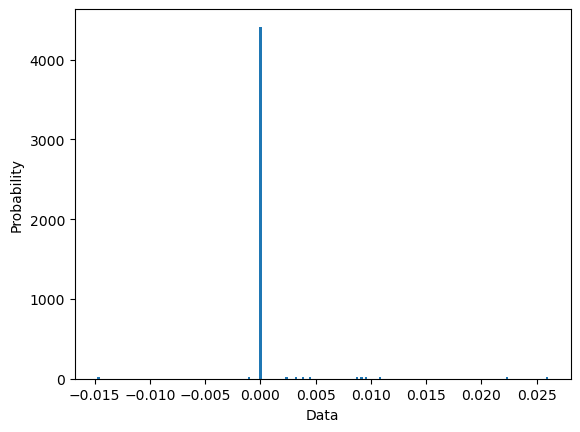

In [79]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

scores = [result.score for result in results]
np.random.seed(42)

plt.hist(scores, density=True, bins=192)  # density=False would make counts
plt.ylabel('Probability')
plt.xlabel('Data');

In [28]:
import bisect
def interquartile_range(results, iqr_multiplier=1):
    # assume sorted in increasing order
    third_quartile = results[int(len(results) * 0.75)].score
    first_quartile = results[int(len(results) * 0.25)].score
    IQR = third_quartile - first_quartile
    outlier_score = third_quartile + iqr_multiplier * IQR
    print(third_quartile, first_quartile, outlier_score)

    by_score = operator.attrgetter('score')
    outliers = results[bisect.bisect(results, outlier_score, key=by_score):]
    return outliers

In [29]:
def n_sigma_rule(results, n=3):
    scores = [r.score for r in results]
    std_dev = np.std(scores)
    mean = np.mean(scores)
    outlier_score = mean + std_dev * n
    print(std_dev, mean, outlier_score)
    by_score = operator.attrgetter('score')
    outliers = results[bisect.bisect(results, outlier_score, key=by_score):]
    return outliers

In [30]:
results.sort(key=operator.attrgetter('score'), reverse=False)
print(interquartile_range(results))
outliers = n_sigma_rule(results, n=2)

0.0 0.0 0.0
[Result(source_node=(11, 15, 10), score=0.0018548392), Result(source_node=(11, 15, 4), score=0.019067267), Result(source_node=(11, 15, 2), score=0.024952246), Result(source_node=(11, 15, 9), score=0.035728082), Result(source_node=(11, 15, 11), score=0.038943022), Result(source_node=(11, 15, 6), score=0.04258111), Result(source_node=(11, 15, 1), score=0.046695523), Result(source_node=(11, 15, 8), score=0.050019845), Result(source_node=(11, 15, 5), score=0.064356476), Result(source_node=(11, 15, 7), score=0.07704689), Result(source_node=(11, 15, 3), score=0.091859534), Result(source_node=(11, 15, 0), score=0.108900346)]
0.014209402 0.0031354437 0.03155424725264311


# One more iteration: Find maximally relevant source nodes to target nodes

In [36]:
target_nodes = [r.source_node for r in outliers]
ranges = [
        [layer for layer in range(12)],
        [sequence_position for sequence_position in range(input_shape[-1])],
        [attention_head_idx for attention_head_idx in range(12)]
    ]

source_nodes = list(itertools.product(*ranges))
# still haven't ruled out 
prop_fn = lambda snl: prop_GPT(encoding_idxs[0:1, :], extended_attention_mask, model, snl, target_nodes=target_nodes, device=device, mean_acts=mean_acts, set_irrel_to_mean=True)
out_decomps, target_decomps = batch_run(prop_fn, source_nodes)

In [41]:
len(target_decomps[0])

2304

In [37]:
results = []
for target_decomp in target_decomps:
    # this is just the same as what we did on BERT, seems like we take the ratio of the l1 norm of rel to l1 norm of irrel, summed over target nodes
    score = 0
    for i in range(len(target_decomp.target_nodes)):
        rels_magnitude = np.mean(abs(target_decomp.rels[i]))
        irrels_magnitude = np.mean(abs(target_decomp.irrels[i]))
        target_node_score = rels_magnitude / (rels_magnitude + irrels_magnitude)
        score += target_node_score
    results.append(Result(target_decomp.source_node), score)

[[<pyfunctions.wrappers.TargetNodeDecompositionList at 0x7fb8d5a94110>,
  ...],
  ...],
  ...],
  ...],
  ...],
  ...],
  ...],
  ...],
  ...],
  ...],
  ...],
  ...]]